# MONOREADER

Extracting the images and importing different libraries

In [1]:
#!gdown --id 1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm
#!unzip images.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm
To: /content/images.zip
100% 940M/940M [00:11<00:00, 82.7MB/s]
Archive:  images.zip
   creating: images/
   creating: images/testing/
   creating: images/testing/flip/
  inflating: images/testing/flip/0001_000000020.jpg  
  inflating: images/testing/flip/0002_000000012.jpg  
  inflating: images/testing/flip/0002_000000013.jpg  
  inflating: images/testing/flip/0002_000000015.jpg  
  inflating: images/testing/flip/0002_000000017.jpg  
  inflating: images/testing/flip/0003_000000005.jpg  
  inflating: images/testing/flip/0003_000000008.jpg  
  inflating: images/testing/flip/0003_000000022.jpg  
  inflating: images/testing/flip/0003_000000025.jpg  
  inflating: images/testing/flip/0004_000000

In [2]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b87f749970a150795f901078709bff35fe7834977e71dd9508ae23c7979a25f4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=50538f8ea2256f664be785c9aa8a5fdfa0aa366d8ec47a50fa6706913dadf1a6
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [4]:
from tqdm.notebook import tqdm
from __future__ import print_function, division
import pandas as pd
from torchsummary import  summary
from termcolor import colored
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import lr_scheduler
from torchvision import datasets
import json
import requests
import os
import time
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
#grad cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# **Data exploration**

In [5]:
train_notflip = os.listdir("/content/images/training/notflip")
train_flip = os.listdir("/content/images/training/flip")

In [6]:
test_notflip = os.listdir("/content/images/testing/notflip")
test_flip = os.listdir("/content/images/testing/flip")

In [7]:
print(' training flipped images:', len(train_flip))
print('training not flipped images:', len(train_notflip))
print('testing flipped images:', len(test_flip))
print('testing not flipped images:', len(test_notflip))

 training flipped images: 1162
training not flipped images: 1230
testing flipped images: 290
testing not flipped images: 307


In [8]:
test_img="/content/images/testing/flip/"+test_flip[0]
img = Image.open(test_img)
print(img.size)

(1080, 1920)


Its height and weight are given as 1080 and 1920. the size will be different in the dataset so we should resize according to the model we are using.

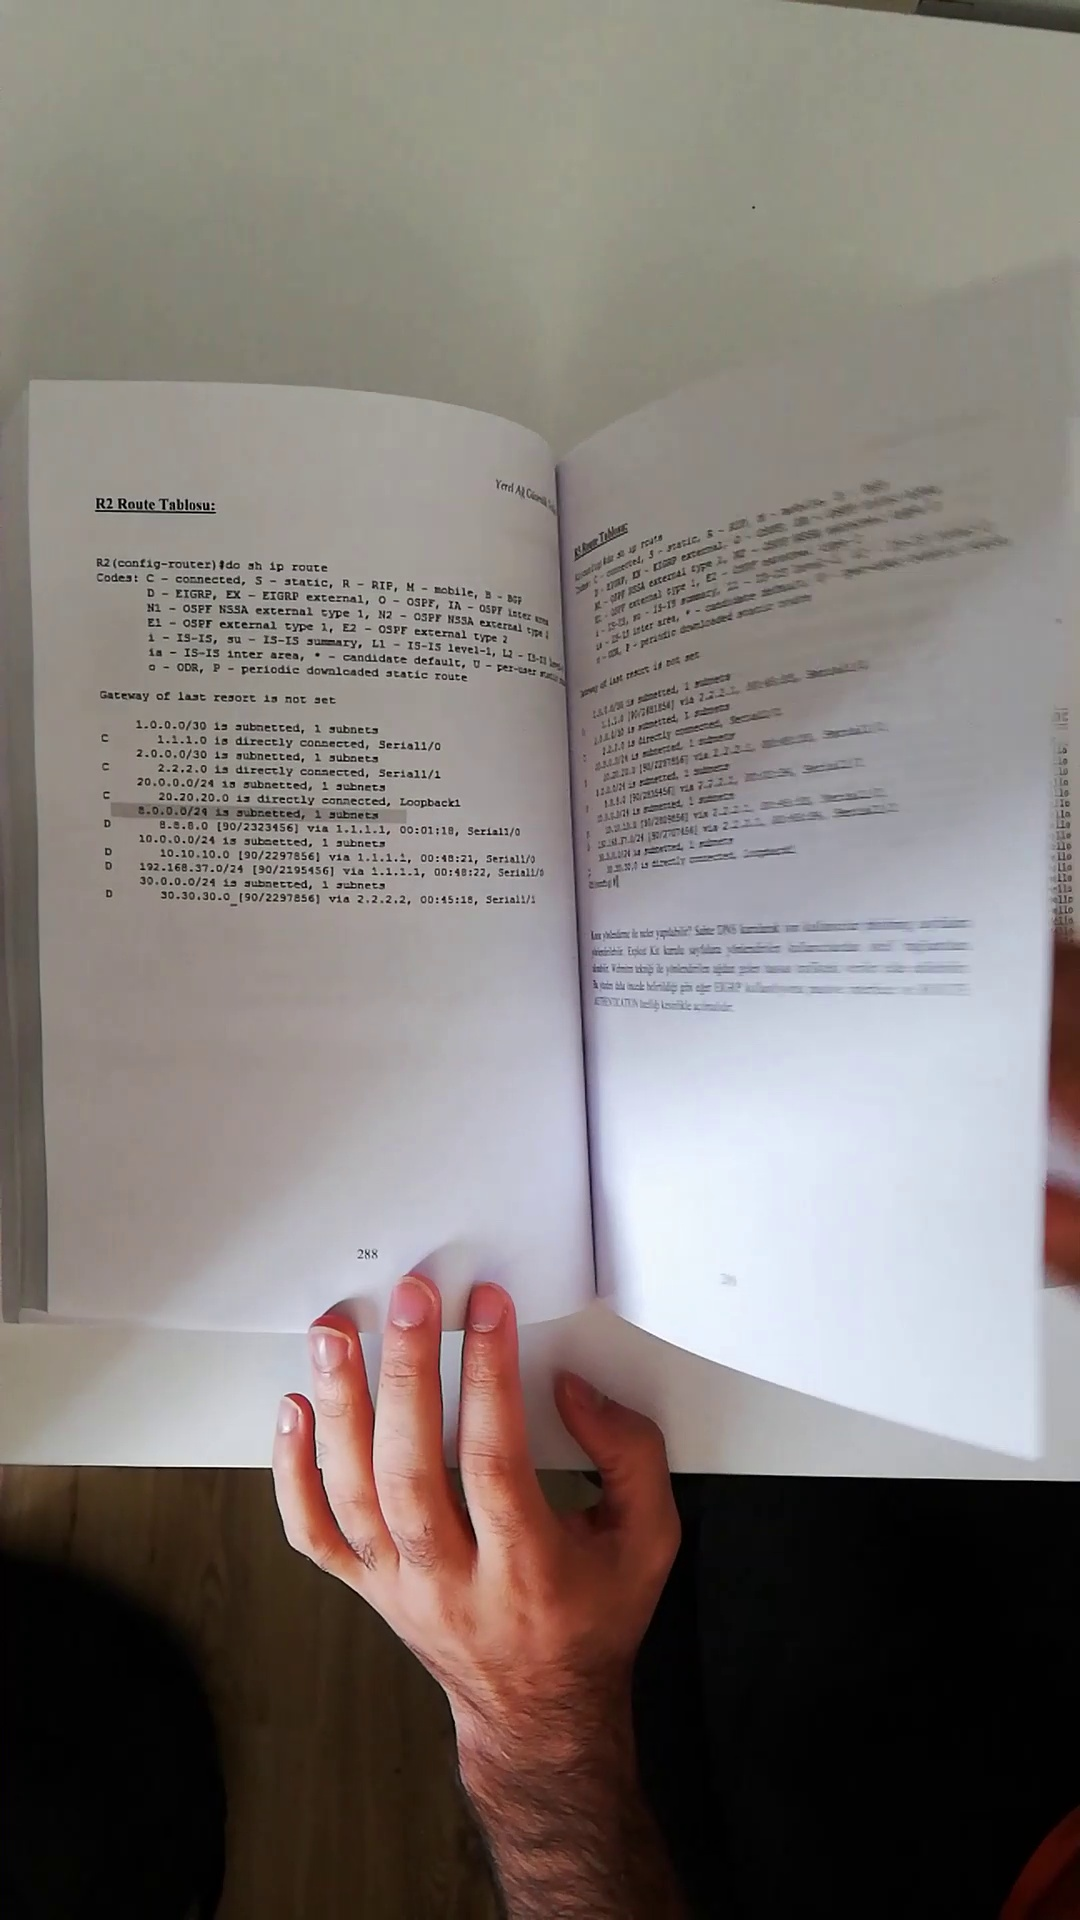

In [9]:
img

here i am labelling 0 for not flipping and 1 for flipping.

In [10]:
X_noflip = np.array(train_notflip)
X_flip = np.array(train_flip)

y_noflip = np.zeros(X_noflip.shape[0])
y_flip = np.ones(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip ))
y = np.concatenate((y_noflip, y_flip))

print (X.shape)
print (y.shape)

(2392,)
(2392,)


Splitting the train data to train data and validation data

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.1, random_state = 100)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2152,), (240,), (2152,), (240,))

There are 2152 images in training dataset and 240 images in the validation dataset.

creating a new folder valid for flip and notflip

In [12]:
import shutil
os.mkdir('/content/images/valid')
os.mkdir('/content/images/valid/flip')
os.mkdir('/content/images/valid/notflip')

for i,j in zip(X_val,y_val):
    if j ==0:# 0 --> flip
      shutil.move('/content/images/training/notflip/'+i,'/content/images/valid/notflip')
    else:
      shutil.move('/content/images/training/flip/'+i,'/content/images/valid/flip')

# **Data Preprocessing**


cropping image

These are some transformation that can be done for the images.

In [13]:
!pip install torchsummary

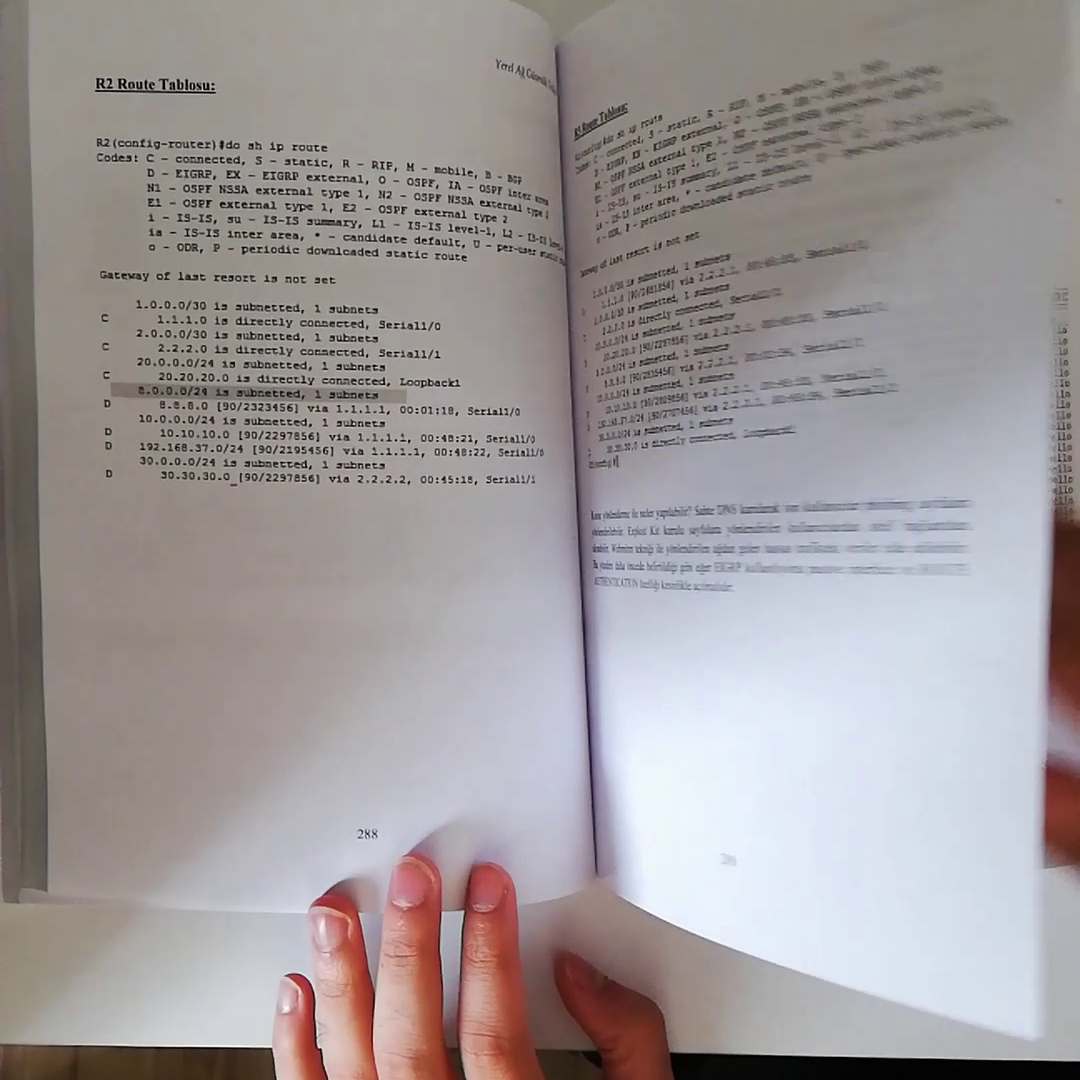

In [14]:
from torchvision import transforms
from PIL import Image
base_size = (1080, 1080)
cropped_img=transforms.CenterCrop(size=base_size)(img)
cropped_img


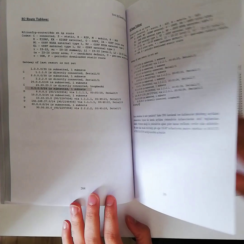

In [15]:
resized_img=transforms.Resize(size=(244,244))(cropped_img)
resized_img

I will be using two type of model:


*   CNN
*   EfficentNet model



Both of them will have different type of transformer.

In [16]:
#CNN transformer
CNN_transforms = {
    "training": transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
}

Here I am cropping image to 1080 and resizing it to 224*224. Also making it to tensor to make its value between 0 and 1.

In [17]:
#EfficentNet transformer
Efficentnet_transforms = {
    'training': transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [18]:
CNN_datasets = {x: datasets.ImageFolder(os.path.join('/content/images/', x),
                                          CNN_transforms[x])
                  for x in ['training', 'valid']}

CNN_train_loader = DataLoader(dataset=CNN_datasets['training'], shuffle=True, batch_size=8)
CNN_val_loader = DataLoader(dataset=CNN_datasets['valid'], shuffle=True, batch_size=1)

Here we are visualizing the dataset

In [20]:
inputs, classes = next(iter(CNN_train_loader))

In [21]:
dataset_sizes = {x: len(CNN_datasets[x]) for x in ['training', 'valid']}
class_names = CNN_datasets['training'].classes
class_names

['flip', 'notflip']

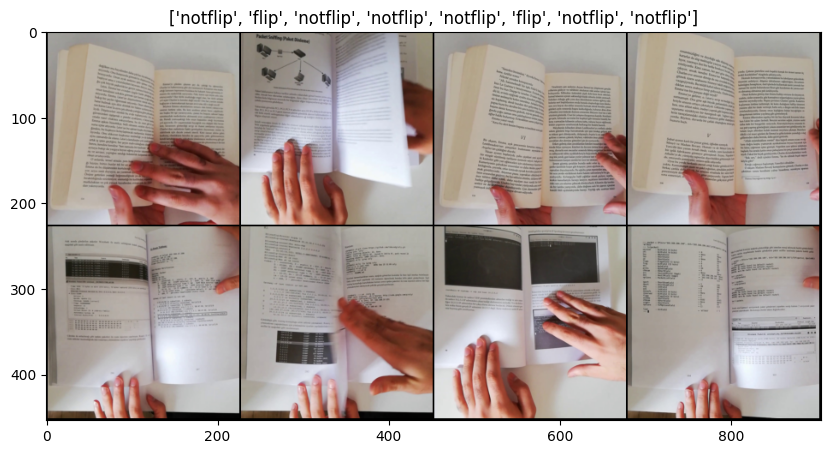

In [22]:
single_batch_grid = utils.make_grid(inputs, nrow=4)#  nrow: Number of images displayed in each row of the grid.
plt.figure(figsize = (10,10))
plt.title([class_names[x] for x in classes])
plt.imshow(single_batch_grid.permute(1, 2, 0),)

# **Modeling**

This is a cnn where there are 3 convolution blocks, lastcnn to capture high features and maxpool for downsampling the feature map.

In [23]:
class flipClassifier(nn.Module):
    def __init__(self):
        super(flipClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=56, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [24]:
CNN_model = flipClassifier()
CNN_model.to('cpu')
print(CNN_model)
criterion = nn.CrossEntropyLoss()#
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

flipClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 2, kernel_size=(56, 56), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


Here the function binary_acc calculates the accuracy of the classifier.

In [25]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [30]:
accuracy_stats_CNN = {
    'train': [],
    "val": []
}
loss_stats_CNN = {
    'train': [],
    "val": []
}

Training takes place

In [ ]:
print("Begin training.")
for e in tqdm(range(1, 13)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    CNN_model.train()
    for X_train_batch, y_train_batch in CNN_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to('cpu'), y_train_batch.to('cpu')
        optimizer.zero_grad()
        y_train_pred = CNN_model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    with torch.no_grad():
        CNN_model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in CNN_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to('cpu'), y_val_batch.to('cpu')
            y_val_pred = CNN_model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats_CNN['train'].append(train_epoch_loss/len(CNN_train_loader))
    loss_stats_CNN['val'].append(val_epoch_loss/len(CNN_val_loader))
    accuracy_stats_CNN['train'].append(train_epoch_acc/len(CNN_train_loader))
    accuracy_stats_CNN['val'].append(val_epoch_acc/len(CNN_val_loader))
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(CNN_train_loader):.5f} | Val Loss: {val_epoch_loss/len(CNN_val_loader):.5f} | Train Acc: {train_epoch_acc/len(CNN_train_loader):.5f} | Val Acc: {val_epoch_acc/len(CNN_val_loader):.5f}')

Begin training.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 8.18465 | Val Loss: 13.28295 | Train Acc: 81.33829 | Val Acc: 74.16667
Epoch 02: | Train Loss: 2.75370 | Val Loss: 12.94020 | Train Acc: 91.57993 | Val Acc: 75.83333
Epoch 03: | Train Loss: 1.96828 | Val Loss: 36.11947 | Train Acc: 94.11896 | Val Acc: 55.83333
Epoch 04: | Train Loss: 1.86593 | Val Loss: 33.33401 | Train Acc: 95.15985 | Val Acc: 62.50000
Epoch 05: | Train Loss: 1.66416 | Val Loss: 16.92661 | Train Acc: 95.81413 | Val Acc: 73.75000
Epoch 06: | Train Loss: 1.96396 | Val Loss: 19.78774 | Train Acc: 94.87732 | Val Acc: 71.25000
Epoch 07: | Train Loss: 0.97999 | Val Loss: 50.62251 | Train Acc: 97.05576 | Val Acc: 58.75000
Epoch 08: | Train Loss: 0.67798 | Val Loss: 26.22303 | Train Acc: 97.70632 | Val Acc: 57.91667
Epoch 09: | Train Loss: 0.86140 | Val Loss: 24.58034 | Train Acc: 97.26766 | Val Acc: 61.25000
Epoch 10: | Train Loss: 0.78178 | Val Loss: 22.58000 | Train Acc: 97.82900 | Val Acc: 69.16667
Epoch 11: | Train Loss: 0.61489 | Val Loss: 20.009

In [ ]:
torch.save(CNN_model.state_dict(), "/content/images/cnn_model.ckpt")

graph of loss and accuracy during the training

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

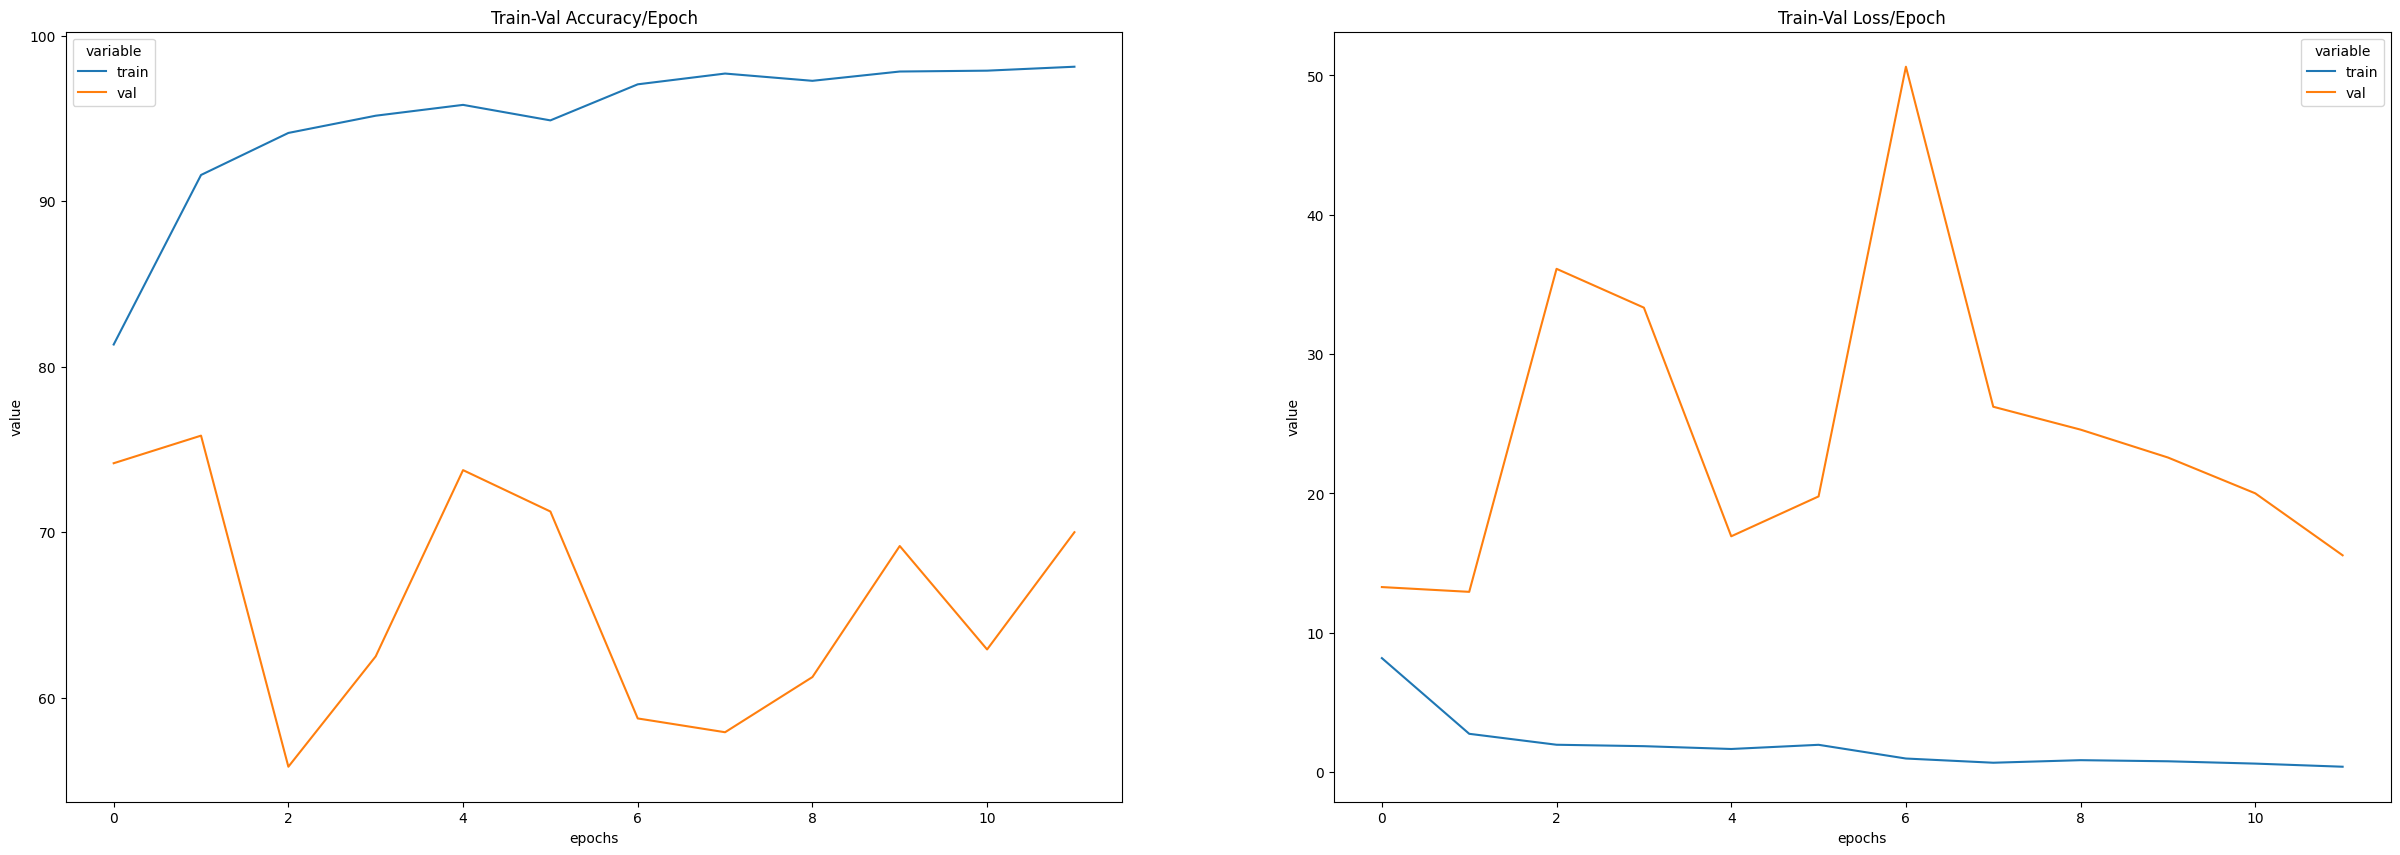

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_CNN).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_CNN).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

we can see that the loss and accuracy function of validation varies throughout the training but for the training dataset the accuracy is increasing gradually.

In [26]:
def valid_batch_loop(model_test,validloader):

        valid_loss = 0.0
        valid_acc = 0.0
        final_y_pred_list=[]
        final_y_true_list=[]
        for images,labels in tqdm(validloader):

            # move the data to CPU
            images = images.to('cpu')
            labels = labels.to('cpu')
            logits = model_test(images)
            acc,y_pred_list,y_true_list=binary_acc_test(logits,labels)
            final_y_pred_list.extend(y_pred_list)
            final_y_true_list.extend(y_true_list)
            valid_acc = valid_acc + acc

        return valid_acc / len(validloader),final_y_pred_list,final_y_true_list

In [27]:
def binary_acc_test(y_pred, y_test):
    y_pred_list=[]
    y_true_list=[]
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    y_pred_list.append(y_pred_tags.cpu().numpy())
    y_true_list.append(y_test.cpu().numpy())
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc,y_pred_list,y_true_list

In [ ]:
cnn_model = flipClassifier().to('cpu')
cnn_model.load_state_dict(torch.load('/content/images/cnn_model.ckpt'))

<All keys matched successfully>

In [ ]:
CNN_test_dataset = datasets.ImageFolder(root='/content/images/testing', transform=CNN_transforms['valid'])
CNN_test_loader = DataLoader(dataset=CNN_test_dataset, shuffle=True, batch_size=1, num_workers=4)

Here the evaluation is done with the testing dataset.

In [ ]:
CNN_model.eval()
avg_test_acc_cnn,final_y_pred_list_cnn,final_y_true_list_cnn = valid_batch_loop(cnn_model,CNN_test_loader)
print("Test Acc cnn: {}".format(avg_test_acc_cnn))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Acc cnn: 70.01675415039062


In [ ]:
print(classification_report([i[0] for i in final_y_true_list_cnn], [i[0][0][0] for i in final_y_pred_list_cnn],digits=4))

              precision    recall  f1-score   support

           0     0.6920    0.6897    0.6908       290
           1     0.7078    0.7101    0.7089       307

    accuracy                         0.7002       597
   macro avg     0.6999    0.6999    0.6999       597
weighted avg     0.7001    0.7002    0.7002       597



We can see that the F1 score is 70 for the CNN model.

# **EfficentNet model**


This is a pretrained model.

In [28]:
Efficentnet_datasets = {x: datasets.ImageFolder(os.path.join('/content/images/', x),
                                          Efficentnet_transforms[x])
                  for x in ['training', 'valid']}

Efficentnet_train_loader = DataLoader(dataset=Efficentnet_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
Efficentnet_val_loader = DataLoader(dataset=Efficentnet_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)


In [29]:
dataset_sizes = {x: len(Efficentnet_datasets[x]) for x in ['training', 'valid']}
class_names = Efficentnet_datasets['training'].classes
class_names

['flip', 'notflip']

the shape of the first image is: torch.Size([3, 224, 224])


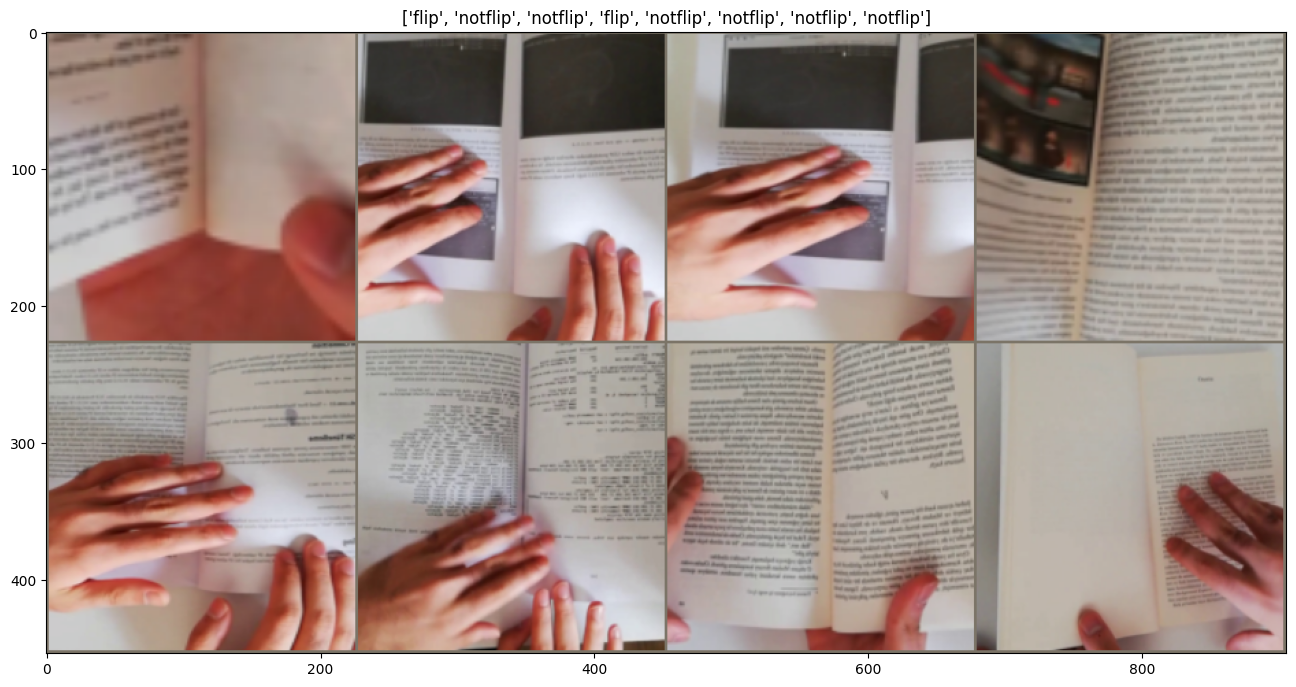

In [30]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(16,16))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(Efficentnet_train_loader))
#see shape of the first image
print("the shape of the first image is:",inputs[0].shape)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)
imshow(out,title=[class_names[x] for x in classes])

In [31]:
B4_model=EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 141MB/s]


Loaded pretrained weights for efficientnet-b4


In [32]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.B4_model = EfficientNet.from_pretrained('efficientnet-b4')

        self.fc = nn.Sequential(
                  nn.Linear(in_features=1000, out_features=512),
                  nn.ReLU(),
                  nn.Dropout(p=0.3),
                  nn.Linear(in_features=512, out_features=2),
)

    def forward(self, x):
        x = self.B4_model(x)
        return self.fc(x)
last_model=Model()

Loaded pretrained weights for efficientnet-b4


In [33]:
#chech the model's layers
last_model.to('cpu')
summary(last_model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 48, 112, 112]           1,296
       BatchNorm2d-3         [-1, 48, 112, 112]              96
MemoryEfficientSwish-4         [-1, 48, 112, 112]               0
         ZeroPad2d-5         [-1, 48, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 48, 112, 112]             432
       BatchNorm2d-7         [-1, 48, 112, 112]              96
MemoryEfficientSwish-8         [-1, 48, 112, 112]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(last_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=3)

In [35]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [37]:
print("Begin training.")
for e in tqdm(range(1, 21)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    loss_best = float('inf')
    last_model.train()

    for X_train_batch, y_train_batch in Efficentnet_train_loader:
        X_train_batch, y_train_batch = X_train_batch.to('cpu'), y_train_batch.to('cpu')
        optimizer.zero_grad()
        y_train_pred = last_model(X_train_batch)
        y_train_batch = y_train_batch.long()


        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    with torch.no_grad():
        last_model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0

        for X_val_batch, y_val_batch in Efficentnet_val_loader:
            X_val_batch, y_val_batch = X_val_batch.to('cpu'), y_val_batch.to('cpu')
            y_val_pred = last_model(X_val_batch)


            y_val_batch = y_val_batch.long()

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)

            if val_loss.item() < loss_best:
                loss_best = val_loss.item()
                name_model = '/content/images/efficentnet_bestmodel_3.ckpt'
                torch.save(last_model.state_dict(), name_model)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats['train'].append(train_epoch_loss / len(Efficentnet_train_loader))
    loss_stats['val'].append(val_epoch_loss / len(Efficentnet_val_loader))
    accuracy_stats['train'].append(train_epoch_acc / len(Efficentnet_train_loader))
    accuracy_stats['val'].append(val_epoch_acc / len(Efficentnet_val_loader))

    scheduler.step(val_epoch_loss / len(Efficentnet_val_loader))

    print(f'Epoch {e + 0:02}: | Train Loss: {train_epoch_loss / len(Efficentnet_train_loader):.5f} | '
          f'Val Loss: {val_epoch_loss / len(Efficentnet_val_loader):.5f} | '
          f'Train Acc: {train_epoch_acc / len(Efficentnet_train_loader):.3f}| '
          f'Val Acc: {val_epoch_acc / len(Efficentnet_val_loader):.3f}')
    print("last lr", scheduler._last_lr)
    print('-' * 12)

print("Training Finished")


Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 0.52262 | Val Loss: 0.22492 | Train Acc: 76.814| Val Acc: 91.667
last lr [0.001]
------------
Epoch 02: | Train Loss: 0.41426 | Val Loss: 1.59375 | Train Acc: 83.948| Val Acc: 56.667
last lr [0.001]
------------
Epoch 03: | Train Loss: 0.41224 | Val Loss: 0.45501 | Train Acc: 83.599| Val Acc: 76.250
last lr [0.001]
------------
Epoch 04: | Train Loss: 0.38887 | Val Loss: 0.29647 | Train Acc: 85.706| Val Acc: 86.667
last lr [0.001]
------------
Epoch 05: | Train Loss: 0.34899 | Val Loss: 0.20257 | Train Acc: 87.368| Val Acc: 90.000
last lr [0.001]
------------
Epoch 06: | Train Loss: 0.33009 | Val Loss: 0.49393 | Train Acc: 87.807| Val Acc: 75.417
last lr [0.001]
------------
Epoch 07: | Train Loss: 0.37602 | Val Loss: 6.06297 | Train Acc: 85.721| Val Acc: 47.083
last lr [0.001]
------------
Epoch 08: | Train Loss: 0.32787 | Val Loss: 0.12093 | Train Acc: 88.067| Val Acc: 99.167
last lr [0.001]
------------
Epoch 09: | Train Loss: 0.28027 | Val Loss: 0.01313 | Tr

Graph of loss and accuracy function during the training.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

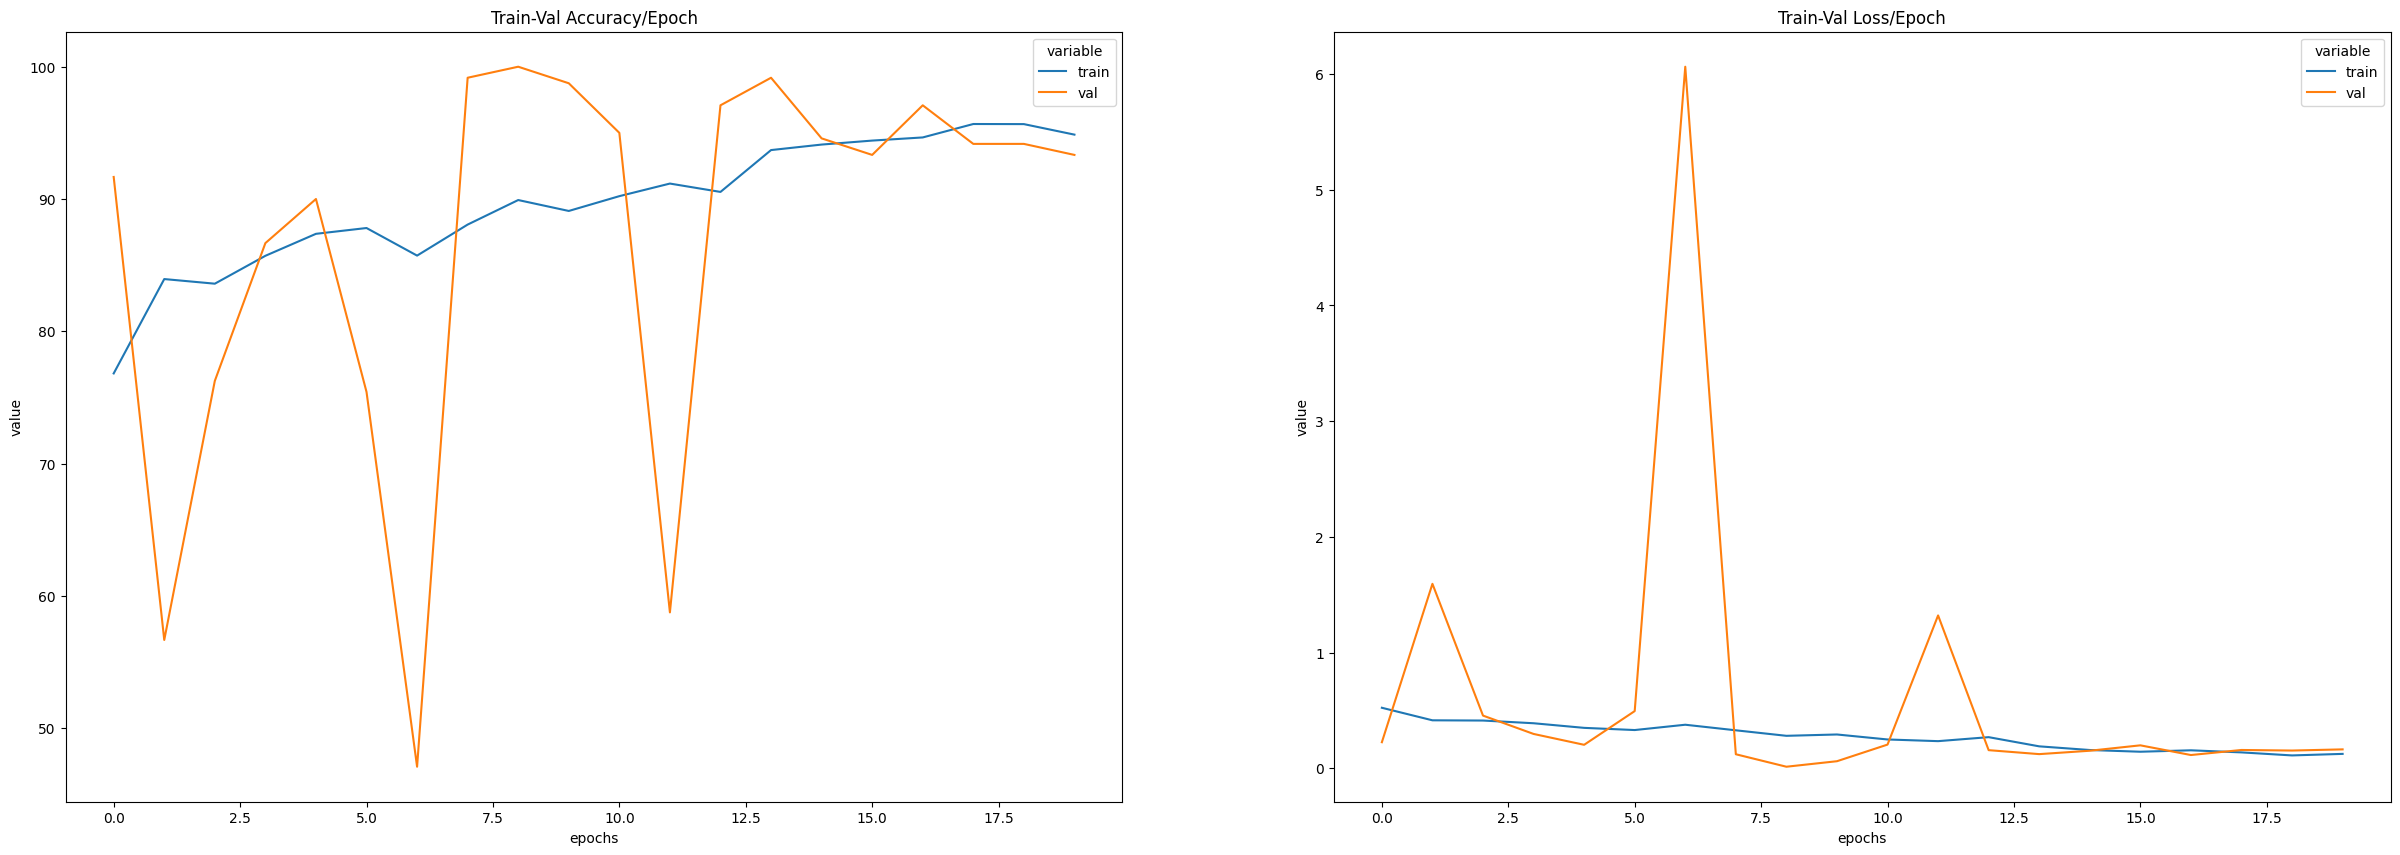

In [38]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

We can see that there is improvement in the accuracy with each epoch for training but for validation it gets varied extremely.

In [39]:
criterion = nn.CrossEntropyLoss()

In [40]:
model_efficent = Model().to('cpu')
model_efficent.load_state_dict(torch.load('/content/images/efficentnet_bestmodel_3.ckpt'))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [41]:
test_dataset = datasets.ImageFolder(root='/content/images/testing/', transform=Efficentnet_transforms['valid'])

In [42]:
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=1, num_workers=4)

Evaluation with the testing dataset

In [43]:
model_efficent.eval()
avg_test_acc,final_y_pred_list,final_y_true_list = valid_batch_loop(model_efficent,test_loader)
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Acc : 94.6398696899414


In [44]:
print(classification_report([i[0] for i in final_y_true_list], [i[0] for i in final_y_pred_list],digits=4))

              precision    recall  f1-score   support

           0     0.9006    1.0000    0.9477       290
           1     1.0000    0.8958    0.9450       307

    accuracy                         0.9464       597
   macro avg     0.9503    0.9479    0.9464       597
weighted avg     0.9517    0.9464    0.9463       597



The F1 score is 94.64 which is much greater than the convolution network that we have used.

In [45]:
print(confusion_matrix(final_y_true_list, final_y_pred_list))

[[290   0]
 [ 32 275]]


We can conclude by saying that Efficientnet is much better than the cnn since efficientnet is also a pretrained model it gives good accuracy and less loss function compared to the cnn. Also the time took to train efficientnet for 20 epochs was over 1 hour but for to train cnn for 12 epoch it took over 2 and half hour. So with time and efficiency efficientnet is better than cnn.